# Object segmentation and classifiation on OpenCL-compatible GPUs
[APOC](https://github.com/haesleinhuepf/apoc) is a python library based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [sklearn](https://scikit-learn.org/stable/). It accelerated Random Forest Classifiers to predict faster on graphics processing units supporting the [OpenCL](https://www.khronos.org/opencl/) standard. For object segmentation, it uses a pixel classifier and connected components labeling.

If there are errors in the first two cells, containing messages such as "module not found: apoc", "module not found: pyclesperanto_prototype" or "clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR"
* Check [these installation instructions](https://github.com/haesleinhuepf/devbio-napari#installation)
* [Install graphics card drivers](https://github.com/haesleinhuepf/devbio-napari#troubleshooting-graphics-cards-drivers) if neccessary

In [1]:
from skimage.io import imread, imshow, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc

Let's start with loading an example image and some ground truth:

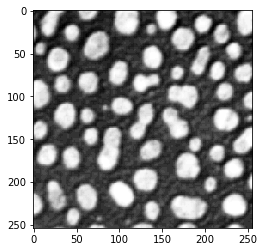

In [2]:
image = imread('../data/blobs.tif')
cle.imshow(image)

In [3]:
if False: # you can use this to make manual annotations
    import napari

    # start napari
    viewer = napari.Viewer()
    napari.run()

    # add image
    viewer.add_image(image)

    # add an empty labels layer and keep it in a variable
    labels = np.zeros(image.shape).astype(int)
    viewer.add_labels(labels)
else:
    labels = imread('../data/blobs_annotations.tif')

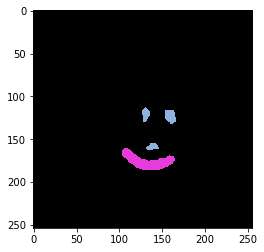

In [4]:
#imsave('annotations.tif', labels)
manual_annotations = labels

cle.imshow(manual_annotations, labels=True)

To see the image and the annotation on top, we overlay both:

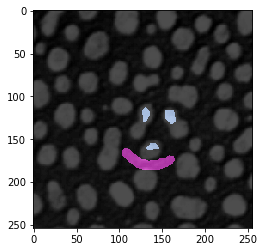

In [5]:
cle.imshow(image, continue_drawing=True)
cle.imshow(manual_annotations, labels=True, alpha=0.7)

## Training
We now train a ObjectSegmenter, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [6]:
# define features
features = "gaussian_blur=1 gaussian_blur=5 sobel_of_gaussian_blur=1"

# this is where the model will be saved
cl_filename = 'my_object_segmenter.cl'

# delete classifier in case the file exists already
apoc.erase_classifier(cl_filename)

# train classifier
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, image)

## Prediction / segmentation
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction. Prediction can be done on the CPU using the original scikit-learn code and on the GPU using the generated OpenCL-code. OCLRFC works well if both result images look identical.

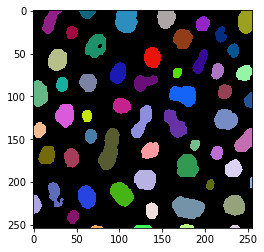

In [7]:
segmentation_result = clf.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

## Segmentation from a loaded segmenter
After training, the segmenter has been stored as a file. This file can be loaded again and applied to other data.

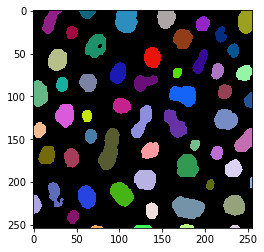

In [8]:
# load segmenter from disk
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename)

# apply it
segmentation_result = clf.predict(image=image)
cle.imshow(segmentation_result, labels=True)

## Object classification
When classifying segmented objects, we need to provide three images: The raw intensity image, a label image representing the objects and an annotation where different objects are marked with different labels. The first two are available above. We load the label annotation from disk. In this `annotation`, lines were drawn through three different kinds of objects:
* Small, round
* Large, round
* Large, elongated

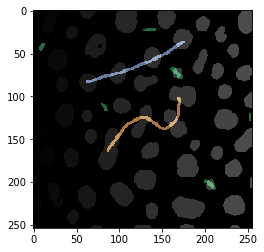

In [9]:
annotation = imread('../data/blobs_label_annotation.tif')

cle.imshow(segmentation_result, continue_drawing=True)
cle.imshow(annotation, labels=True, alpha=0.7)

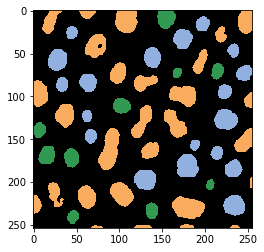

In [10]:
# for the classification we define size and shape as criteria
features = 'area mean_max_distance_to_centroid_ratio'

# This is where the model will be saved
cl_filename_object_classifier = "my_object_classifier.cl"

# delete classifier in case the file exists already
apoc.erase_classifier(cl_filename_object_classifier)

# train the classifier
classifier = apoc.ObjectClassifier(cl_filename_object_classifier)
classifier.train(features, segmentation_result, annotation, image)

# determine object classification
classification_result = classifier.predict(segmentation_result, image)
cle.imshow(classification_result, labels=True)

## Exercise
Use the graphical user interface of napari and change `blobs_label_annotation.tif` so that the classifier trained here differentiates two classes: Round and elongated objects.

Optional: [Use the graphical user interface of APOC](https://github.com/haesleinhuepf/napari-accelerated-pixel-and-object-classification#object-classification).